In [1]:
import xarray as xr
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import timedelta
from timeit import default_timer
import xhistogram.xarray as xhx
import seaborn as sns
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 14
})
import matplotlib.colors as colors




In [2]:
dummy = xr.open_mfdataset("/pscratch/sd/a/amahesh/hens/demo_bred_1step/ensemble_out_0000*_2020-06-18-00-00-00.nc",
                     group='global', concat_dim='ensemble', combine='nested')

In [14]:
def load_hens_min_mse(curr_date, curr_date_idx):
    stats_ds = xr.open_dataset(f"/pscratch/sd/a/amahesh/hens_h5/stats/t2m_{curr_date:%Y%m%d}_reduced-lead-04-07-10.h5")
    stats_ds = stats_ds.rename({"phony_dim_4" : 'ensemble_size',
                    "phony_dim_2" : 'lat',
                     "phony_dim_3" : 'lon',
                     'phony_dim_1' : 'time'})
    stats_ds['lat'] = dummy['lat']
    stats_ds['lon'] = dummy['lon']
    # Select 10 day lead time
    return stats_ds['t2m_min_mse_bootstrap_mean'].isel(phony_dim_0=curr_date_idx)
def load_hens_min_mse_interval(curr_date, curr_date_idx):
    stats_ds = xr.open_dataset(f"/pscratch/sd/a/amahesh/hens_h5/stats/t2m_{curr_date:%Y%m%d}_reduced-lead-04-07-10.h5")
    stats_ds = stats_ds.rename({"phony_dim_4" : 'ensemble_size',
                "phony_dim_2" : 'lat',
                 "phony_dim_3" : 'lon',
                 'phony_dim_1' : 'time',
                 'phony_dim_5' : 'interval'})
    stats_ds['lat'] = dummy['lat']
    stats_ds['lon'] = dummy['lon']
    return stats_ds['t2m_min_mse_interval'].isel(phony_dim_0=curr_date_idx)

def load_ifs(ifs_ds, curr_date):
    ifs = ifs_ds.sel(time=f"{curr_date:%Y-%m-%d}", drop=True).rename({'latitude' : 'lat', 
                                                      'longitude' : 'lon'})
    ifs = ifs.sel(step=slice(np.timedelta64(10, 'D'),np.timedelta64(258, 'h')))
    return ifs['t2m'].values
    
def load_analysis(curr_date):
    valid_date = curr_date + timedelta(days=10)
    print(valid_date)
    analysis = xr.open_dataset(f"/pscratch/sd/a/amahesh/tigge/analysis/ifs_analysis-2023-{valid_date.month:02d}.grib")
    true_t2m = analysis['t2m'].sel(time=f"{valid_date:%Y-%m-%d}").rename({'latitude' : 'lat', 
                                                  'longitude' : 'lon'})
    return true_t2m.load()

def load_era5(curr_date):
    valid_date = curr_date + timedelta(days=10)
    print(valid_date)
    true = xr.open_dataset("/pscratch/sd/p/pharring/74var-6hourly/staging/2023.h5", mode='r')
    true = true.rename({'phony_dim_0' : 'time',
                        'phony_dim_2' : 'lat', 
                 'phony_dim_3' : 'lon',
                 'phony_dim_1' : 'channel'})
    true['lat'] = dummy['lat']
    true['lon'] = dummy['lon']
    true['channel'] = ["u10m", "v10m", "u100m", "v100m", "t2m", "sp", "msl", "tcwv", "2d", "u50", "u100", "u150", "u200", "u250", "u300", "u400", "u500", "u600", "u700", "u850", "u925", "u1000", "v50", "v100", "v150", "v200", "v250", "v300", "v400", "v500", "v600", "v700", "v850", "v925", "v1000", "z50", "z100", "z150", "z200", "z250", "z300", "z400", "z500", "z600", "z700", "z850", "z925", "z1000", "t50", "t100", "t150", "t200", "t250", "t300", "t400", "t500", "t600", "t700", "t850", "t925", "t1000", "q50", "q100", "q150", "q200", "q250", "q300", "q400", "q500", "q600", "q700", "q850", "q925", "q1000"]
    true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')

    true = true.sel(time=f"{valid_date:%Y-%m-%d}")
    true_t2m = true['fields'].sel(channel='t2m')
    return true_t2m

def load_mu_sigma(curr_date):
    valid_date = curr_date + timedelta(days=10)
    print(valid_date)
    mu, sigma = [],[]
    for hour in [0,6,12,18]:
        mu.append(xr.open_zarr(f"/pscratch/sd/a/amahesh/hens/thresholds/t2m_mean_{valid_date.month:02d}_{hour:02d}/").rename({'VAR_2T' : 't2m',
                        'latitude' : 'lat', 
                        'longitude' : 'lon'}))
        sigma.append(xr.open_zarr(f"/pscratch/sd/a/amahesh/hens/thresholds/t2m_std_{valid_date.month:02d}_{hour:02d}/").rename({'VAR_2T' : 't2m',
                        'latitude' : 'lat', 
                        'longitude' : 'lon'}))
    mu = xr.concat(mu, dim='time')
    sigma = xr.concat(sigma, dim='time')
    return mu['t2m'], sigma['t2m']

In [42]:
def group_by_leadtime_by_size(hens_min_mse):
    lat_rad = np.deg2rad(hens_min_mse['lat'])
    weights = np.cos(lat_rad)

    # Initialize an empty list to store the results
    results = []

    # Loop over lead_time and ensemble_size
    for lead_time in hens_min_mse['time']:
        current=[]
        for ensemble in hens_min_mse['ensemble_size']:
            # Select the data for the current lead_time and ensemble_size
            data = hens_min_mse.sel(time=lead_time, ensemble_size=ensemble)

            # Calculate the weighted mean
            weighted_mean = data.weighted(weights).mean(('lat', 'lon'))
            # Assign lead_time and ensemble_size as coordinates
            weighted_mean = weighted_mean.expand_dims({'lead_time': [lead_time], 'ensemble_size': [ensemble]})
            current.append(weighted_mean)

            # Append the result to the list
        results.append(current)

    # Concatenate all the results into a single DataArray
    return xr.combine_nested(results, concat_dim=['lead_time', 'ensemble_size'])

In [ ]:
dates = pd.date_range('2023-06-01', '2023-08-31', freq='D')
all_min_mse, all_era5_zscore, global_mean_min_mse = [], [], []
for idx, curr_date in enumerate(dates):
    start = default_timer()
    hens_min_mse = load_hens_min_mse(curr_date, idx)
    all_min_mse.append(hens_min_mse.isel(time=[8,9,10,11]).load())
    era5 = load_era5(curr_date)
    
    mu, sigma = load_mu_sigma(curr_date)
    
    era5_zscore = (era5 - mu)/sigma
    all_era5_zscore.append(era5_zscore.load())
    print('finished in ', default_timer() - start)
    # global_mean_min_mse.append(group_by_leadtime_by_size(hens_min_mse).load())
   
   



In [10]:
dates = pd.date_range('2023-06-01', '2023-08-31', freq='D')
all_min_mse_interval = []
for idx, curr_date in enumerate(dates):    
    start = default_timer()
    hens_min_mse = load_hens_min_mse_interval(curr_date, idx)
    all_min_mse_interval.append(hens_min_mse.isel(time=[8,9,10,11]))
    print('finished in ', default_timer() - start)
   
   



finished in  0.009664834011346102
finished in  0.008622302004368976
finished in  0.008535964996553957
finished in  0.008733958005905151
finished in  0.008421934995567426
finished in  0.008493283006828278
finished in  0.008492031003697775
finished in  0.008437776006758213
finished in  0.008464076992822811
finished in  0.008518221002304927
finished in  0.008421053003985435
finished in  0.00836292099847924
finished in  0.008377810008823872
finished in  0.008449408007436432
finished in  0.0084934019978391
finished in  0.00835740999900736
finished in  0.008354183999472298
finished in  0.008322102003148757
finished in  0.008428599001490511
finished in  0.00827510200906545
finished in  0.008236387991928495
finished in  0.008291804988402873
finished in  0.008506697995471768
finished in  0.00836438499391079
finished in  0.008648802002426237
finished in  0.00838946299336385
finished in  0.008325389004312456
finished in  0.008333374003996141
finished in  0.008409640999161638
finished in  0.008460

In [7]:
dates = pd.date_range('2023-06-01', '2023-08-31', freq='D')
all_era5_zscore = []
for idx, curr_date in enumerate(dates):
    start = default_timer()
    
    era5 = load_era5(curr_date)
    
    mu, sigma = load_mu_sigma(curr_date)
    
    era5_zscore = (era5 - mu)/sigma
    all_era5_zscore.append(era5_zscore.load().reset_index('time'))
    print('finished in ', default_timer() - start)
   
   



2023-06-11 00:00:00
2023-06-11 00:00:00
finished in  10.236916490001022
2023-06-12 00:00:00
2023-06-12 00:00:00
finished in  9.774894050002331
2023-06-13 00:00:00
2023-06-13 00:00:00
finished in  10.074533666003845
2023-06-14 00:00:00
2023-06-14 00:00:00
finished in  9.390155237997533
2023-06-15 00:00:00
2023-06-15 00:00:00
finished in  9.591141075987252
2023-06-16 00:00:00
2023-06-16 00:00:00



KeyboardInterrupt



In [8]:
all_era5_zscore = xr.concat(all_era5_zscore, dim='initial_time')

In [ ]:
all_min_mse = xr.concat(all_min_mse, dim='initial_time')

In [119]:
all_min_mse_interval = xr.concat(all_min_mse_interval, dim='initial_time')

In [122]:
all_min_mse_interval.to_zarr("/pscratch/sd/a/amahesh/temp/all_min_mse_interval.zarr")

In [51]:
all_era5_zscore.to_zarr("/pscratch/sd/a/amahesh/temp/all_era5_zscore.zarr")
# all_min_mse.to_zarr("/pscratch/sd/a/amahesh/temp/all_min_mse.zarr")


In [53]:
all_era5_zscore = xr.open_zarr("/pscratch/sd/a/amahesh/temp/all_era5_zscore.zarr").load()
all_era5_zscore = all_era5_zscore.rename({'__xarray_dataarray_variable__' : 'Ensemble Minimum RMSE (K)'})

In [54]:
all_min_mse = xr.open_zarr("/pscratch/sd/a/amahesh/temp/all_min_mse.zarr").load()
all_min_mse_interval = xr.open_zarr("/pscratch/sd/a/amahesh/temp/all_min_mse_interval.zarr").load()


In [55]:
weights = np.cos(np.deg2rad(all_min_mse.lat))
all_min_mse_interval = all_min_mse_interval.assign_coords({'ensemble_size' : [50, 100, 500, 1000, 5000, 7424]})
all_min_mse_interval = all_min_mse_interval.rename({'t2m_min_mse_interval' : 'Ensemble Minimum RMSE (K)'})

In [56]:
all_min_mse = all_min_mse.assign_coords({'ensemble_size' : [50, 100, 500, 1000, 5000, 7424]})
all_min_mse = all_min_mse.rename({'t2m_min_mse_bootstrap_mean' : 'Ensemble Minimum RMSE (K)'})

In [127]:
vals = xr.where(np.logical_and(np.abs(all_era5_zscore) > sigma, np.abs(all_era5_zscore) < sigma+1), all_min_mse, np.nan)


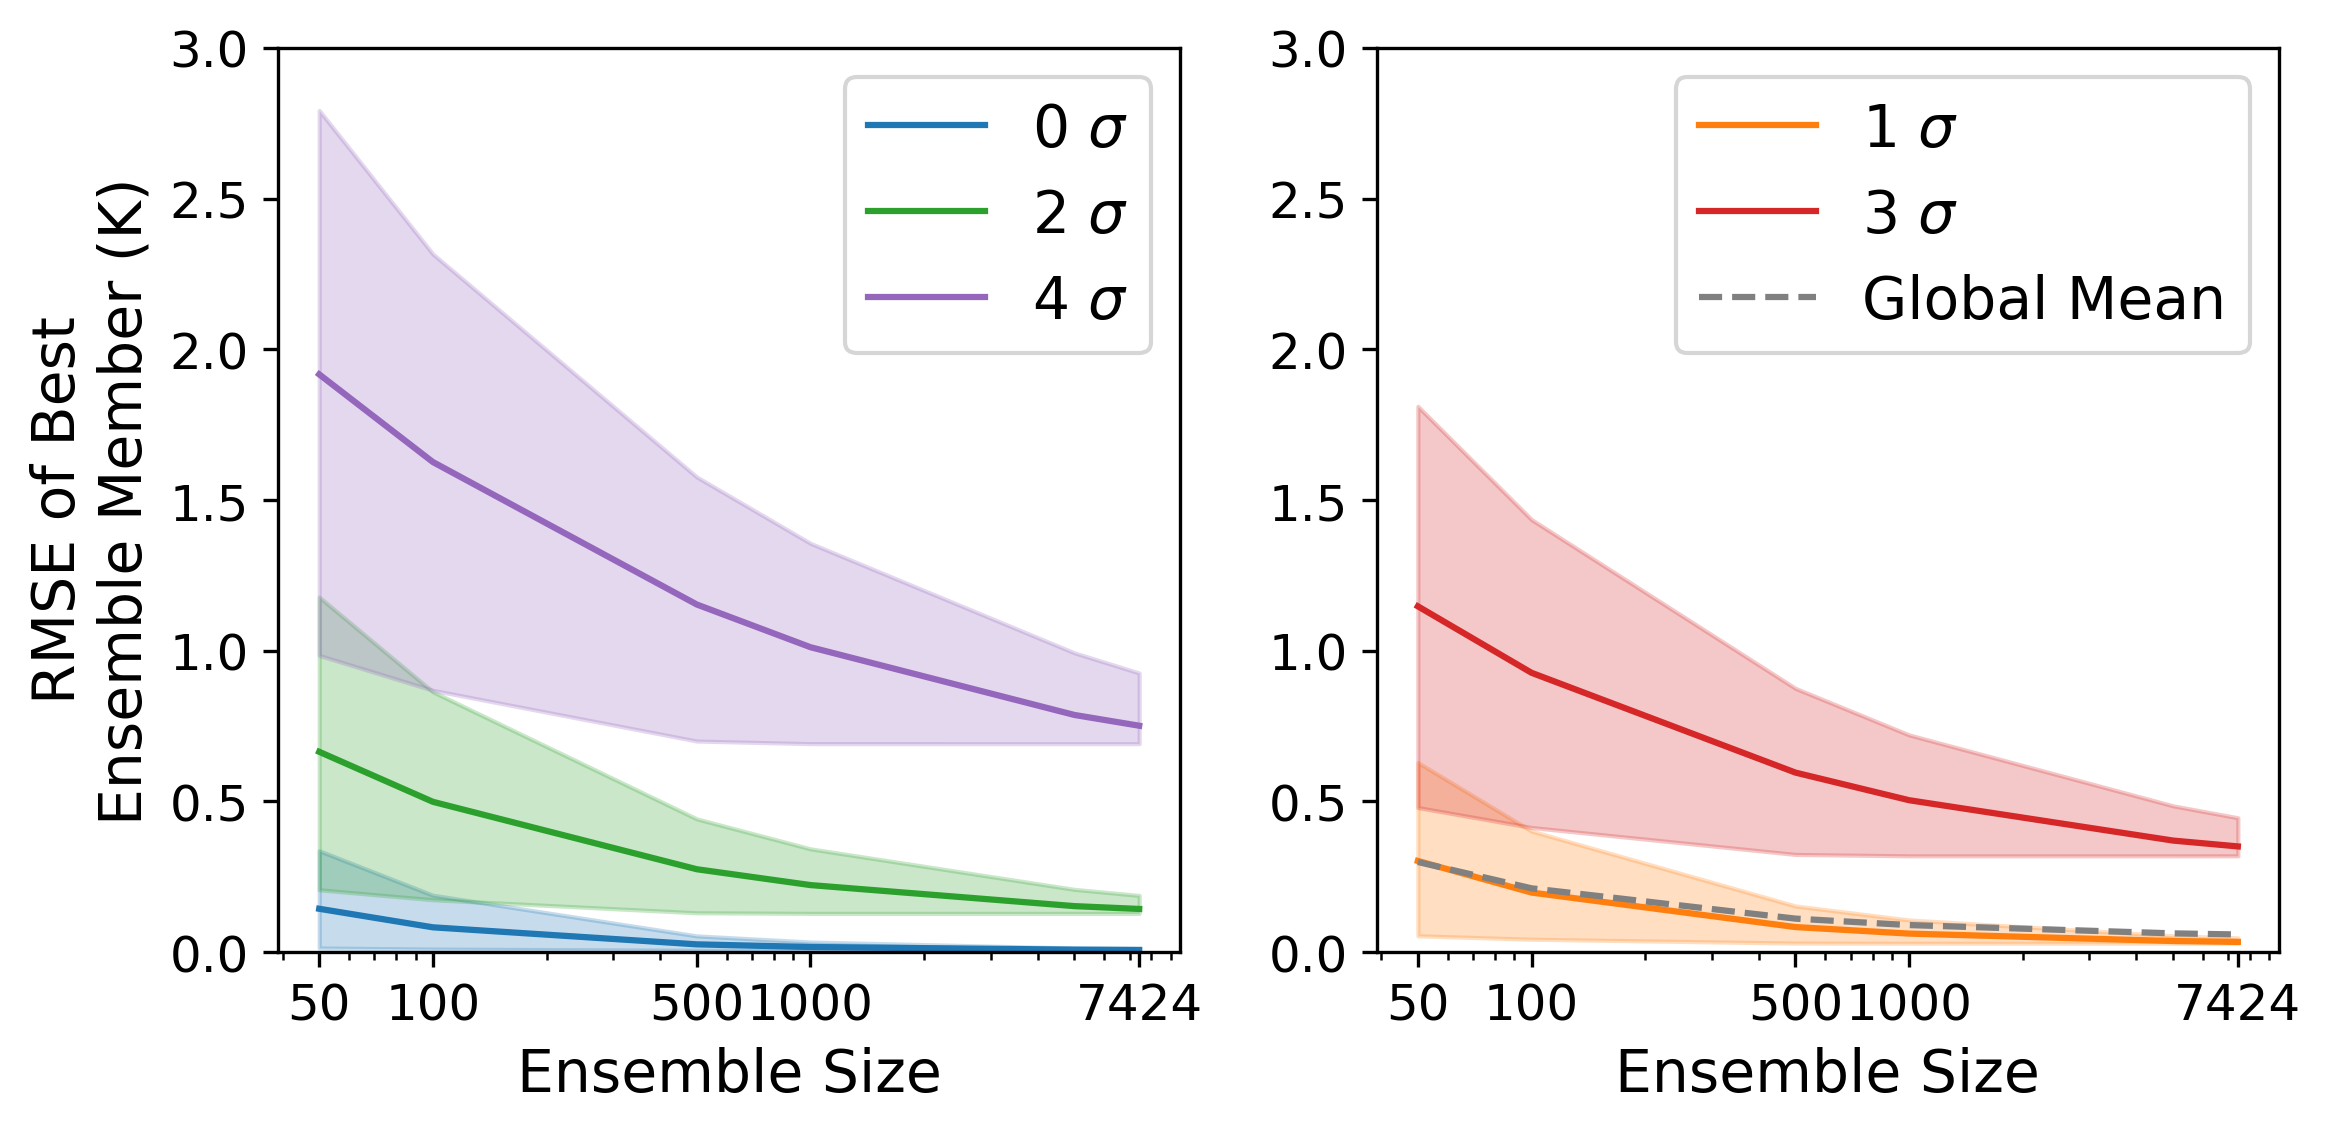

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

fig, axs = plt.subplots(1, 2, figsize=(8, 4), dpi=300)

# Define sigma groups for each panel
left_panel_sigmas = [0, 2, 4]
right_panel_sigmas = [1, 3]

# Function to plot for a given panel and sigma values
def plot_sigma(ax, sigmas):
    for sigma in sigmas:
        subset = np.sqrt(xr.where(np.logical_and(np.abs(all_era5_zscore) > sigma, np.abs(all_era5_zscore) < sigma+1), all_min_mse, np.nan).weighted(weights).mean(('lat', 'lon')).mean(('initial_time', 'time')))
        subset_interval_low = np.sqrt(xr.where(np.logical_and(np.abs(all_era5_zscore) > sigma, np.abs(all_era5_zscore) < sigma+1), all_min_mse_interval.isel(interval=0), np.nan).weighted(weights).mean(('lat', 'lon')).mean(('initial_time', 'time')))
        subset_interval_high = np.sqrt(xr.where(np.logical_and(np.abs(all_era5_zscore) > sigma, np.abs(all_era5_zscore) < sigma+1), all_min_mse_interval.isel(interval=1), np.nan).weighted(weights).mean(('lat', 'lon')).mean(('initial_time', 'time')))

        ax.plot(subset['ensemble_size'], subset['Ensemble Minimum RMSE (K)'].values, label='{} $\sigma$'.format(sigma), color=f"C{sigma}")
        ax.fill_between(subset['ensemble_size'],
                        subset_interval_low['Ensemble Minimum RMSE (K)'].values,
                        subset_interval_high['Ensemble Minimum RMSE (K)'].values,
                        color=f"C{sigma}", alpha=0.25)

    if 1 in sigmas:
        global_mean = np.sqrt(all_min_mse.weighted(weights).mean(('lat', 'lon')).mean(('initial_time', 'time')))
        ax.plot(global_mean['ensemble_size'], global_mean['Ensemble Minimum RMSE (K)'].values, label='Global Mean', color='gray', linestyle='dashed')
    else:
        ax.set_ylabel("RMSE of Best \nEnsemble Member (K)")
    ax.set_xscale("log")
    ax.set_xlabel("Ensemble Size")
    ax.set_xticks([50, 100, 500, 1000, 7424])
    ax.set_xticklabels([50, 100, 500, 1000, 7424])
    ax.set_ylim((0, 3))
    ax.legend()

# Plot for left panel
plot_sigma(axs[0], left_panel_sigmas)

# Plot for right panel
plot_sigma(axs[1], right_panel_sigmas)

plt.tight_layout()
plt.savefig("rmse_best_member.pdf")
plt.show()
